# Transfer Learning

Image classification models have millions of parameters. Training them from scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

**Transfer learning** is the process of applying existing machine learning models to scenarios for which they were not originally intended. This leveraging can save training time and extend the usefulness of existing machine learning models, models which may have had the available data and computation to have been trained for very long periods of time on very large datasets. If we train a model on a large set of data, we can then refine the result to be effective on our smaller amount of data. At least, that's the idea.

Documentation:

https://www.tensorflow.org/tutorials/images/transfer_learning

# Import **tensorflow** Library

Import the library and alias it:

In [1]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is active:

In [2]:
tf.__version__, tf.test.gpu_device_name()

('2.4.1', '/device:GPU:0')

# Pre-trained Models for Transfer Learning

If we don't have enough training data, it is often a good idea to reuse the lower layers of a pre-trained model. **Transfer learning** is the process of creating new AI models by fine-tuning previously trained neural networks. Instead of training a neural network from scratch, we can download a pretrained, open-source deep learning model and fine tune it for our own purpose.

To implement transfer learning, we reuse parts of a pre-trained model and change the final layer (or several layers) of the model. We then retrain those layers on our own dataset.

# Simple Transfer Learning with TensorFlow Hub

We model Flowers data by using pre-trained TF2 SavedModels from TensorFlow Hub for image feature extraction. The pre-trained models were trained on very large and general datasets.

We use two pre-trained TensorFlow Hub models to do transfer learning. **TensorFlow Hub** is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. We begin with the MobileNet v2 pre-trained model. We then use the Inception v3 pre-trained model and compare results between the two.

Resources:

https://www.tensorflow.org/hub

https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

# MobileNet v2 Example

Information about MobileNet and other pre-trained models is avaliable at the following URL:

https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

## Load flowers as TFDS

Split 75% for train set, 15% for validation set, and 25% for test set:

In [3]:
import tensorflow_datasets as tfds

(test, valid, train), info = tfds.load(
    'tf_flowers', as_supervised=True,
    split = ['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    with_info=True, try_gcs=True)

## Get Metadata

Display general information:

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

Display number examples in data splits:

In [5]:
num_train_img = info.splits['train[25%:]'].num_examples
num_valid_img = info.splits['train[10%:25%]'].num_examples
num_test_img = info.splits['train[:10%]'].num_examples
print ('train images:', num_train_img)
print ('valid images:', num_valid_img)
print ('test images:', num_test_img)

train images: 2752
valid images: 551
test images: 367


Calculate number of examples in data splits manually to verify:

In [6]:
num_train_examples = 0
num_valid_examples = 0
num_test_examples = 0

for example in train:
  num_train_examples += 1

for example in valid:
  num_valid_examples += 1

for example in test:
  num_test_examples += 1

print('Total Number of Training Images: {}'\
      .format(num_train_examples))
print('Total Number of Validation Images: {}'\
      .format(num_valid_examples))
print('Total Number of Testing Images: {}'\
      .format(num_test_examples))

Total Number of Training Images: 2752
Total Number of Validation Images: 551
Total Number of Testing Images: 367


Get labels:

In [7]:
class_labels = info.features['label'].names
class_labels

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

Get number of classes:

In [8]:
num_classes = info.features['label'].num_classes
num_classes

5

## Display Examples

Display some examples with **show_examples**:

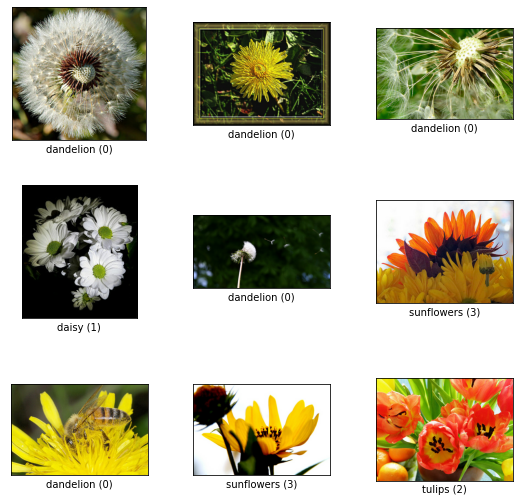

In [9]:
fig = tfds.show_examples(train, info)

## Inspect Images

Display shapes to check images sizes:

In [10]:
for i, example in enumerate(train.take(5)):
  print('Image {} shape: {} label: {}'\
        .format(i+1, example[0].shape,
                example[1]))

Image 1 shape: (240, 240, 3) label: 0
Image 2 shape: (375, 500, 3) label: 0
Image 3 shape: (334, 500, 3) label: 0
Image 4 shape: (240, 207, 3) label: 1
Image 5 shape: (265, 500, 3) label: 0


The images in the flowers dataset are not all the same size. So, we must resize images to a standard size to make them consumable by TensorFlow models.

## Build the Input Pipeline

Create a function to reformat all images to the resolution expected by MobileNet v2 (224, 224) and scale them. The function takes an 'image' and a 'label' as arguments and returns the new 'image' and corresponding 'label' in the desired form.

In [13]:
def format_image(image, label):
  image = tf.image.resize(image, (224, 224)) /255.0
  return image, label

Map function to train, validation, and test sets. And, apply other transformations:

In [14]:
BATCH_SIZE = 367

train_batches = train.shuffle(num_train_img//4).\
  map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = valid.map(format_image).\
  batch(BATCH_SIZE).prefetch(1)

test_batches = test.map(format_image).\
  batch(BATCH_SIZE).prefetch(1)  

## Simple Transfer Learning with MobileNet-v2

We begin the process by creating  a feature_extractor. The partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the TensorFlow Hub documentation (https://tfhub.dev/s?module-type=image-feature-vector) to see a list of available feature vectors.

To get information about MobileNet-v2:

https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

Resource:

https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c03_exercise_flowers_with_transfer_learning_solution.ipynb

### Create a Feature Extractor

Create a feature_extractor using the MobileNet-v2 feature vector. A **feature extractor** is the partial model from TensorFlow Hub (without the final classification layer).

To see a list of available feature vectors, visit:

https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

Click on one of them, read the documentation, and get the corresponding URL to get the feature vector.

Create the feature extractor:

In [15]:
import tensorflow_hub as hub

piece1 = 'https://tfhub.dev/google/tf2-preview/'
piece2 = 'mobilenet_v2/feature_vector/4'
URL = piece1 + piece2
feature_extractor_mn = hub.KerasLayer(
    URL, input_shape=(224, 224, 3))

The feature extractor is now a partial MobileNet-v2 model.

## Freeze the Pretrained Model

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer:

In [16]:
feature_extractor_mn.trainable = False

## Attach a Classification Head

Create a classification head to leverage the pre-trained model for the dataset, which consists of a simple sequential model that includes the pre-trained model and the new classification layer.

Import libraries:

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Clear previous models and generate seed:

In [18]:
import numpy as np

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Build model:

In [19]:
mobile_model = tf.keras.Sequential([
  feature_extractor_mn,
  Dropout(0.5),
  Dense(num_classes)])

Inspect model:

In [20]:
mobile_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile

Compile **SparseCategoricalCrossentropy**:

In [22]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

mobile_model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train

Train model on train and validation sets for six epochs:

In [23]:
EPOCHS = 6

history = mobile_model.fit(
    train_batches, epochs=EPOCHS,
    validation_data=validation_batches)

Epoch 1/6
8/8 [==============================] - 23s 521ms/step - loss: 1.9418 - accuracy: 0.2734 - val_loss: 1.0901 - val_accuracy: 0.5898
Epoch 2/6
8/8 [==============================] - 3s 372ms/step - loss: 1.2399 - accuracy: 0.5043 - val_loss: 0.7611 - val_accuracy: 0.7423
Epoch 3/6
8/8 [==============================] - 3s 371ms/step - loss: 0.9303 - accuracy: 0.6489 - val_loss: 0.6261 - val_accuracy: 0.7822
Epoch 4/6
8/8 [==============================] - 3s 369ms/step - loss: 0.7637 - accuracy: 0.7277 - val_loss: 0.5419 - val_accuracy: 0.8040
Epoch 5/6
8/8 [==============================] - 3s 366ms/step - loss: 0.6388 - accuracy: 0.7640 - val_loss: 0.5016 - val_accuracy: 0.8258
Epoch 6/6
8/8 [==============================] - 3s 372ms/step - loss: 0.5926 - accuracy: 0.7926 - val_loss: 0.4687 - val_accuracy: 0.8421


We get good accuracy with just 6 epochs because MobileNet-v2 was carefully designed over a long time by experts and then trained on a massive dataset (ImageNet).

## Visualize Performance

Plot model performance:

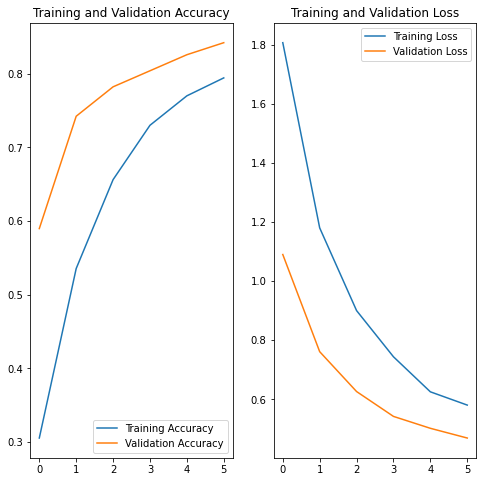

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Make Predictions from Test Data

Predict on **test_batches**:

In [25]:
predictions = mobile_model.predict(test_batches)

Test data is pure because we haven't seen it yet!

Display class labels:

In [26]:
class_labels

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

### Inspect the First Prediction

Get the first prediction array:

In [27]:
predictions[0]

array([-4.889483 , -2.9024162,  4.513405 , -2.9588428,  0.3680797],
      dtype=float32)

The returned array is the raw prediction.

Use the np.argmax() function to get the prediction for the first image:

In [28]:
predicted_id = np.argmax(predictions[0])
predicted_id

2

Convert the label to its class name:

In [29]:
class_labels[predicted_id]

'tulips'

Get the actual labels from the first batch:

In [30]:
for img, lbl in test_batches.take(1):
  print (lbl)

tf.Tensor(
[2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1 0 0 1 1 0
 3 0 4 4 3 0 4 3 3 2 4 0 1 2 1 3 0 1 4 1 0 2 3 0 0 4 0 1 1 0 1 2 4 3 3 0 3
 2 2 1 0 3 2 0 0 4 3 0 3 3 2 0 2 1 4 0 3 3 3 1 4 0 4 4 4 4 0 4 2 3 4 0 0 4
 4 4 2 2 4 4 3 3 0 3 2 0 1 2 1 4 3 0 2 0 2 2 4 0 3 0 0 1 2 0 1 2 3 1 2 2 0
 3 3 4 0 4 0 4 0 2 2 1 0 2 4 0 0 0 1 1 0 4 1 4 4 3 1 0 1 2 3 4 0 0 3 2 4 1
 0 0 4 4 2 0 3 4 0 0 1 3 2 0 2 2 3 4 0 1 4 1 0 1 2 1 2 2 2 1 0 4 2 4 1 0 0
 4 2 1 0 3 2 1 4 3 1 3 0 0 2 3 4 0 1 2 4 0 3 1 0 1 2 4 0 4 4 2 3 0 4 1 2 2
 4 2 2 3 3 0 0 0 2 4 0 2 2 2 2 0 3 1 4 2 3 3 3 2 0 3 3 4 4 4 4 2 3 3 3 0 0
 2 0 4 1 0 0 4 3 0 0 0 4 0 2 4 1 3 0 2 3 3 0 2 4 4 2 0 0 0 0 4 0 1 0 2 0 0
 2 0 0 1 0 1 0 4 1 1 3 1 4 2 4 0 3 3 4 0 0 1 4 3 1 1 0 4 0 1 2 0 3 3], shape=(367,), dtype=int64)


Get the first label:

In [31]:
class_labels[lbl[0].numpy()]

'tulips'

The prediction is correct if the actual label matches the prediction.

### Inspect the First Batch of Predictions

Alternatively, we can convert *test_batches* to an iterator:

In [32]:
image_batch, label_batch = next(iter(test_batches))

images = image_batch.numpy()
labels = label_batch.numpy()

class_labels[labels[0]]

'tulips'

Get the first batch from test_batches iterator with **next**, convert images and labels to NumPy, and display the first label.

Display labels from the first batch:

In [33]:
labels

array([2, 3, 3, 4, 3, 0, 0, 0, 0, 1, 3, 2, 4, 1, 2, 1, 2, 4, 2, 2, 0, 0,
       0, 2, 0, 3, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 4, 4, 3, 0, 4,
       3, 3, 2, 4, 0, 1, 2, 1, 3, 0, 1, 4, 1, 0, 2, 3, 0, 0, 4, 0, 1, 1,
       0, 1, 2, 4, 3, 3, 0, 3, 2, 2, 1, 0, 3, 2, 0, 0, 4, 3, 0, 3, 3, 2,
       0, 2, 1, 4, 0, 3, 3, 3, 1, 4, 0, 4, 4, 4, 4, 0, 4, 2, 3, 4, 0, 0,
       4, 4, 4, 2, 2, 4, 4, 3, 3, 0, 3, 2, 0, 1, 2, 1, 4, 3, 0, 2, 0, 2,
       2, 4, 0, 3, 0, 0, 1, 2, 0, 1, 2, 3, 1, 2, 2, 0, 3, 3, 4, 0, 4, 0,
       4, 0, 2, 2, 1, 0, 2, 4, 0, 0, 0, 1, 1, 0, 4, 1, 4, 4, 3, 1, 0, 1,
       2, 3, 4, 0, 0, 3, 2, 4, 1, 0, 0, 4, 4, 2, 0, 3, 4, 0, 0, 1, 3, 2,
       0, 2, 2, 3, 4, 0, 1, 4, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 4, 2, 4, 1,
       0, 0, 4, 2, 1, 0, 3, 2, 1, 4, 3, 1, 3, 0, 0, 2, 3, 4, 0, 1, 2, 4,
       0, 3, 1, 0, 1, 2, 4, 0, 4, 4, 2, 3, 0, 4, 1, 2, 2, 4, 2, 2, 3, 3,
       0, 0, 0, 2, 4, 0, 2, 2, 2, 2, 0, 3, 1, 4, 2, 3, 3, 3, 2, 0, 3, 3,
       4, 4, 4, 4, 2, 3, 3, 3, 0, 0, 2, 0, 4, 1, 0,

Convert the batch of labels to named labels:

In [34]:
named_labels = [class_labels[labels[i]]
                for i, lbl in enumerate(range(BATCH_SIZE))]
named_labels

['tulips',
 'sunflowers',
 'sunflowers',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'sunflowers',
 'tulips',
 'roses',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'roses',
 'sunflowers',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'roses',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'dandelion',
 'daisy',
 'roses',
 'daisy',
 'dandelion',
 'tulips',
 'sunflowers',
 'dandelion',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'tulips',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'da

Get predictions from the first batch:

In [35]:
predicted_batch = [np.argmax(predictions[i])
                   for i, _ in enumerate(range(BATCH_SIZE))]
predicted_batch

[2,
 1,
 3,
 2,
 3,
 3,
 0,
 0,
 0,
 1,
 2,
 0,
 4,
 1,
 2,
 1,
 2,
 4,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 3,
 3,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 3,
 1,
 2,
 0,
 3,
 0,
 4,
 3,
 3,
 2,
 2,
 0,
 1,
 2,
 1,
 3,
 3,
 4,
 4,
 2,
 2,
 2,
 3,
 0,
 0,
 3,
 0,
 1,
 1,
 0,
 1,
 3,
 2,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 0,
 3,
 2,
 0,
 0,
 4,
 3,
 0,
 3,
 3,
 2,
 0,
 2,
 1,
 4,
 0,
 3,
 2,
 3,
 1,
 4,
 0,
 2,
 4,
 4,
 4,
 0,
 4,
 0,
 3,
 4,
 0,
 0,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 3,
 3,
 0,
 3,
 2,
 0,
 1,
 2,
 1,
 4,
 3,
 0,
 1,
 0,
 2,
 4,
 4,
 0,
 3,
 0,
 3,
 1,
 2,
 0,
 1,
 4,
 3,
 1,
 4,
 2,
 0,
 3,
 3,
 4,
 0,
 4,
 0,
 4,
 0,
 4,
 2,
 1,
 0,
 2,
 4,
 0,
 0,
 0,
 1,
 1,
 0,
 4,
 1,
 4,
 4,
 3,
 0,
 0,
 1,
 2,
 3,
 2,
 0,
 0,
 3,
 2,
 1,
 1,
 0,
 0,
 4,
 4,
 2,
 0,
 3,
 4,
 0,
 0,
 2,
 3,
 2,
 0,
 2,
 2,
 3,
 4,
 0,
 1,
 4,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 4,
 2,
 4,
 1,
 0,
 2,
 4,
 0,
 1,
 0,
 3,
 2,
 1,
 4,
 2,
 1,
 3,
 0,
 0,
 2,
 3,
 4,
 0,
 1,
 2,
 4,
 0,
 3,
 1,
 3,
 1,
 2,
 4,
 0,


Convert predictions to named predictions:

In [36]:
named_pred = [class_labels[predicted_batch[i]]
              for i, lbl in enumerate(range(BATCH_SIZE))]
named_pred

['tulips',
 'daisy',
 'sunflowers',
 'tulips',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'tulips',
 'dandelion',
 'roses',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'sunflowers',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'daisy',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'tulips',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'sunflowers',
 'roses',
 'roses',
 'tulips',
 'tulips',
 'tulips',
 'sunflowers',
 'dandelion',
 'dandelion',
 'sunflowers',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'sunflowers',
 'tulips',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'tulips',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelio

## Plot Model Predictions

The visualization shows actual images from the first test batch. If the prediction is correct, the title is blue. If not, the title is red. If the prediction is incorrect, the prediction is displayed along with the actual label in parentheses.

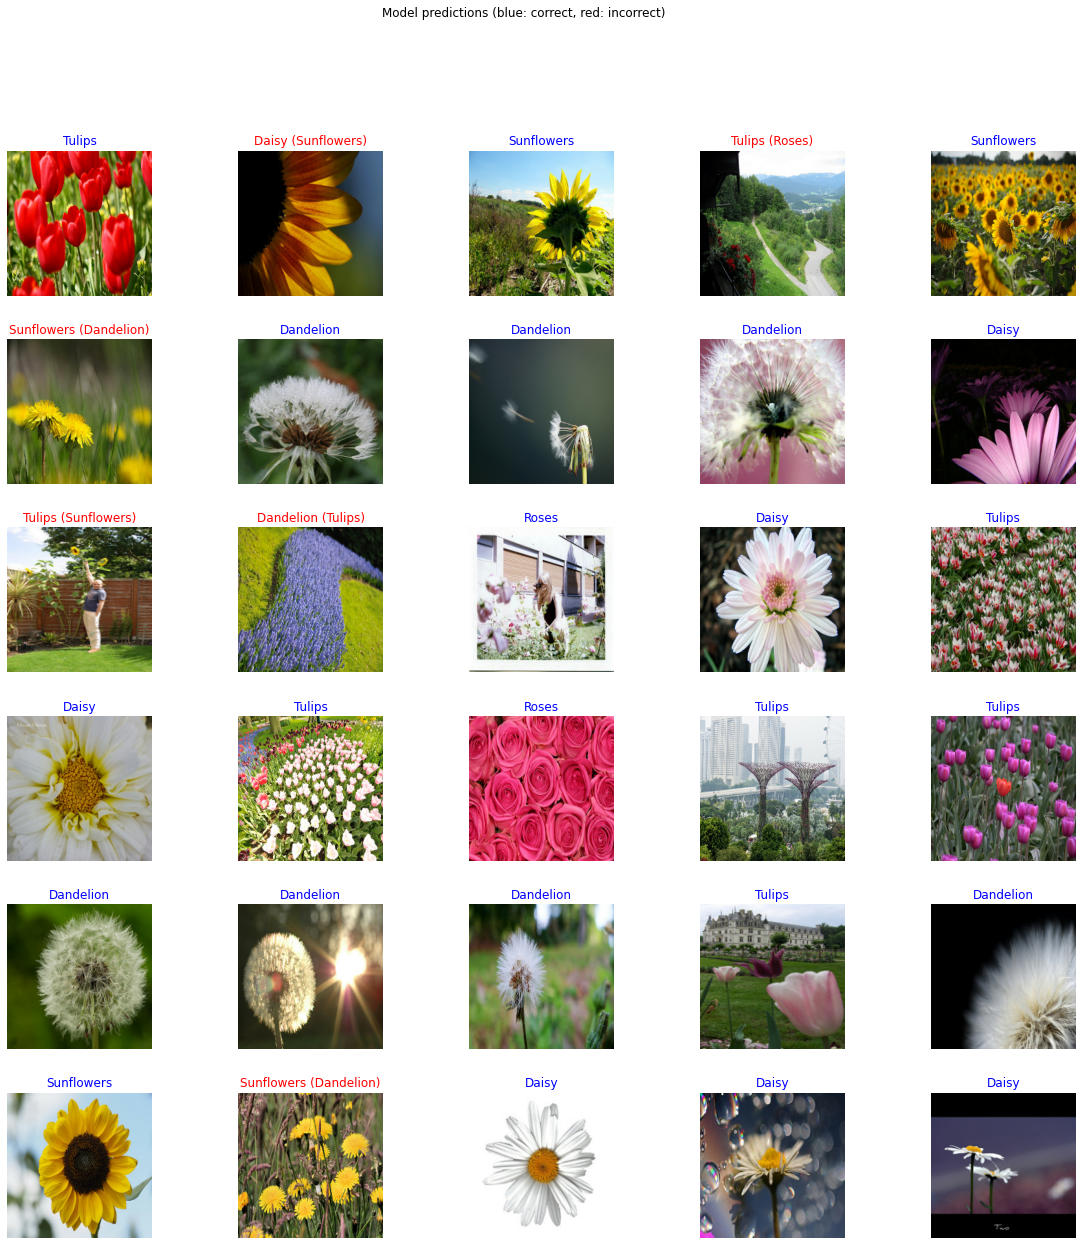

In [37]:
plt.figure(figsize=(20,20))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(images[n])
  color = 'blue' if labels[n] == predicted_batch[n] else 'red'
  if labels[n] != predicted_batch[n]:
    t = named_pred[n].title() +\
        ' (' +named_labels[n].title() + ')'
  else:
    t = named_pred[n].title()
  plt.title(t, color=color)
  plt.axis('off')
  st = 'Model predictions (blue: correct, red: incorrect)'
_ = plt.suptitle(st)

# Perform Transfer Learning with the Inception Model

Use the Inception model to compare against MobileNet. To get the model, peruse https://tfhub.dev/s?module-type=image-feature-vector&q=tf2 and click on 'tf2-preview/inception_v3/feature_vector'. This feature vector corresponds to the Inception v3 model. Use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception takes as input images that are 299 x 299 pixels.

## Reformat Images and Create Batches

Recreate the **format_image** function to reformat images to the resolution expected by Inception v3 (299, 299), and scale them:

In [38]:
def format_image(image, label):
  image = tf.image.resize(image, (299, 299)) / 255.0
  return image, label

## Build an Input Pipeline for Inception

Shuffle train data, reformat, batch, and prefetch train, validation, and test data:

In [39]:
BATCH_SIZE = 367

train_im = train.shuffle(num_train_img//4).\
  map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_im = valid.map(format_image).\
  batch(BATCH_SIZE).prefetch(1)

test_im = test.map(format_image).\
  batch(BATCH_SIZE).prefetch(1)

## Create a Feature Extractor

Create a feature_extractor using the Inception v3 feature vector. A **feature extractor** is the partial model from TensorFlow Hub (without the final classification layer).

To see a list of available feature vectors, visit:

https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

Click on one of them, read the documentation, and get the corresponding URL to get the feature vector.

Create the feature extractor:

In [40]:
piece1 = 'https://tfhub.dev/google/tf2-preview/'
piece2 = 'inception_v3/feature_vector/4'
URL = piece1 + piece2
feature_extractor_im = hub.KerasLayer(URL,
  input_shape=(299, 299, 3),
  trainable=False)

Freeze the pre-trained layers:

In [41]:
feature_extractor_im.trainable = False

Clear and seed:

In [42]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Create the Inception Model



We've already set the stage with MobileNet. So we just need to subtitute the Inception feature extractor:

In [43]:
inception_model = tf.keras.Sequential([
  feature_extractor_im,
  Dropout(0.5),
  Dense(num_classes)])

## Compile

Compile with **SparseCategoricalCrossentropy(from_logits=True)**:

In [44]:
inception_model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train

Train model for six epochs:

In [45]:
EPOCHS = 6

history = inception_model.fit(
    train_im, epochs=EPOCHS,
    validation_data=validation_im)

Epoch 1/6
8/8 [==============================] - 19s 1s/step - loss: 1.7288 - accuracy: 0.2451 - val_loss: 1.0842 - val_accuracy: 0.6479
Epoch 2/6
8/8 [==============================] - 7s 815ms/step - loss: 1.0969 - accuracy: 0.5873 - val_loss: 0.7962 - val_accuracy: 0.7332
Epoch 3/6
8/8 [==============================] - 7s 815ms/step - loss: 0.8019 - accuracy: 0.7103 - val_loss: 0.6507 - val_accuracy: 0.7804
Epoch 4/6
8/8 [==============================] - 7s 815ms/step - loss: 0.6752 - accuracy: 0.7553 - val_loss: 0.5826 - val_accuracy: 0.8076
Epoch 5/6
8/8 [==============================] - 7s 816ms/step - loss: 0.5820 - accuracy: 0.7889 - val_loss: 0.5309 - val_accuracy: 0.8203
Epoch 6/6
8/8 [==============================] - 7s 815ms/step - loss: 0.5381 - accuracy: 0.8086 - val_loss: 0.4909 - val_accuracy: 0.8294


## Visualize

Visualize model performance:

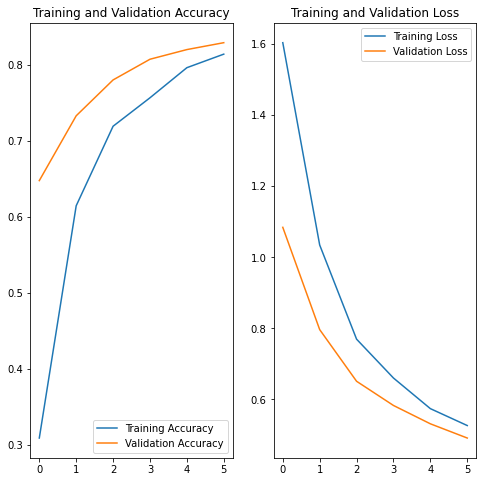

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

Make predictions:

In [48]:
im_predictions = inception_model.predict(test_im)

Get a batch of predictions and convert them to named predictions:

In [49]:
im_pred_batch = [np.argmax(im_predictions[i])
                 for i, _ in enumerate(range(BATCH_SIZE))]
im_named_pred = [class_labels[im_pred_batch[i]]
                 for i, lbl in enumerate(range(BATCH_SIZE))]

Grab the first batch of images and labels from the test set:

In [50]:
im_image_batch, im_label_batch = next(iter(test_im))

im_images = im_image_batch.numpy()
im_labels = im_label_batch.numpy()

Convert the labels to named labels:

In [51]:
im_named_labels = [class_labels[im_labels[i]]
                   for i, lbl in enumerate(range(BATCH_SIZE))]

## Plot Model Predictions

Create a function to display predictions:

In [52]:
def plot_pred(images, labels, named_labels, named_pred):
  plt.figure(figsize=(20,20))
  for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(images[n])
    color = 'blue' if named_labels[n] == named_pred[n] else 'red'
    if named_labels[n] != named_pred[n]:
      t = named_pred[n].title() +\
      ' (' +named_labels[n].title() + ')'
    else:
      t = named_pred[n].title()
    plt.title(t, color=color)
    plt.axis('off')
    st = 'Model predictions (blue: correct, red: incorrect)'
    _ = plt.suptitle(st)

Invoke the function:

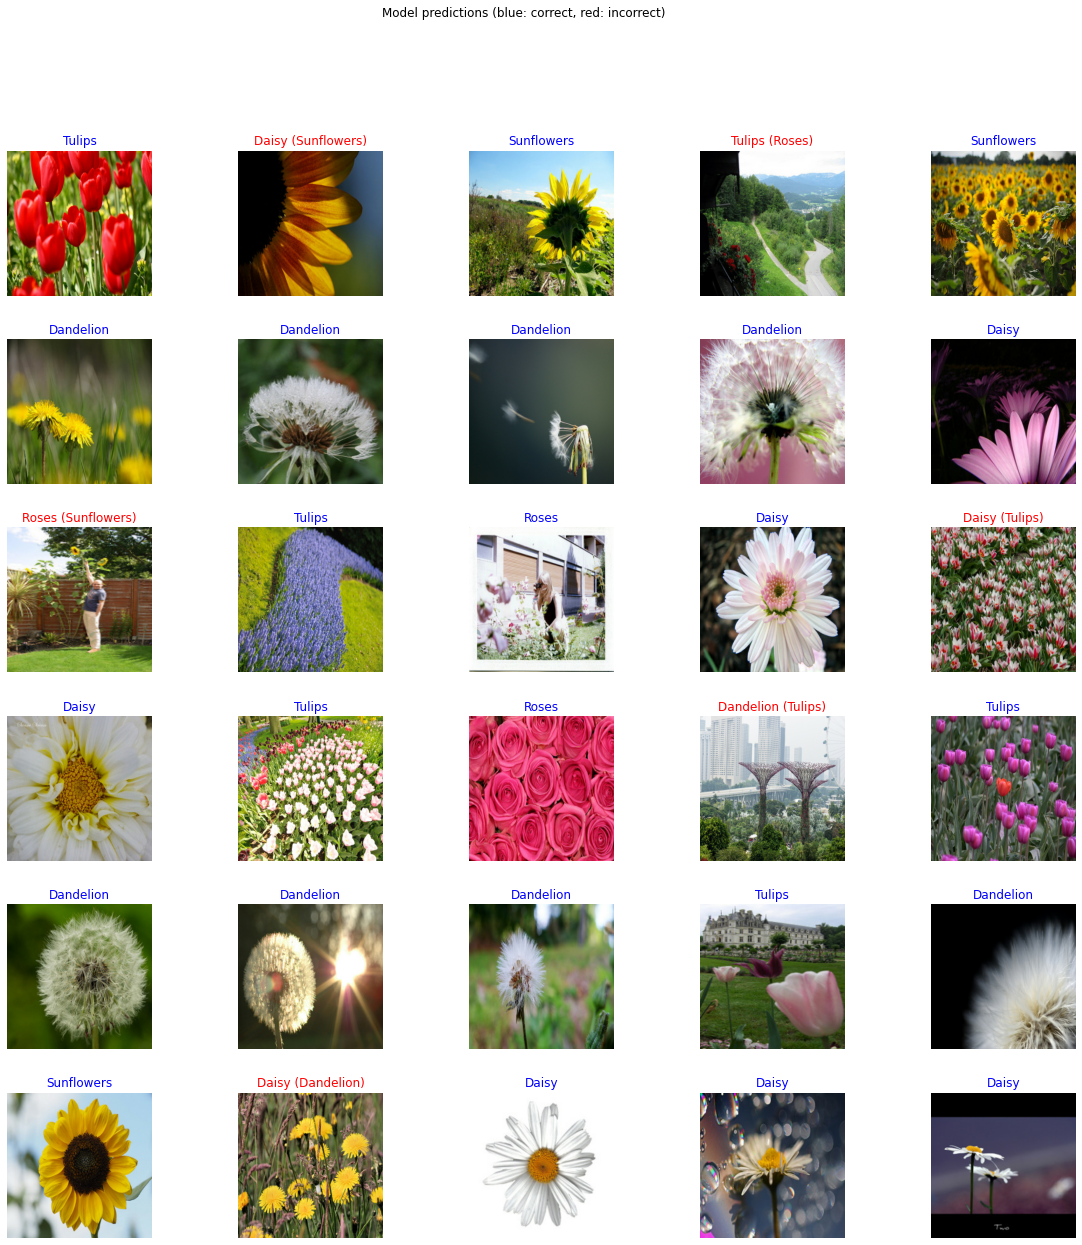

In [53]:
plot_pred(im_images, im_labels, im_named_labels, im_named_pred)